Lets say that we want to calculate some integral on interval a to b using monte carlo method but don't know how many points should be sampled to achive desired accuracy.
Now let n be number of points we sample. Start by seting some n_start value and some n_end value, just a guess as well as some n_step value which will be used to check every n_step'th value between n_start and n_end i.e. checking every value between 50 and 5000 is not needed so with setting n_step to 50 we only check every 50'th value of n. A value of sets (or k) can be used to artificially increase n, every n value will be sampled k times and acual result is mean of all results for given n. 

Because getting random points from everywhere is not very usefull lets limit max and min y values a random point can get.

In [6]:
def min_max(function, a: float,  b: float, eps = 1000) -> tuple:
        n = int(abs(b - a)*eps)
        min_val = function(a)
        max_val = function(b)
        for i in range(n):
            cur = function(a + i / eps)
            if cur < min_val:
                min_val = cur
            if cur > max_val:
                max_val = cur
        return (min_val, max_val)

With that we can start calculating integrals. Final effect should look something like this:

In [5]:
def check_all_n_values(a, b, function, n_start, n_end, n_step, sets):
    for n in range(n_start, n_end + 1, n_step): #n_end+1 because n_end should be inclusive
        for k in range(sets):
            for _ in range(n):
                integrate(a, b, function)

Now how one calulates integral of a function using monte carlo method? Lets start with sampling n points from inside box with one side going from start to end of integration interval and the other side from mininal value to maximal value of function being integrated (on integration interval). 

When function value is positive sampled point aslo has to be positive and below function graph then count it as +1 when it's below function graph, for point = (x,y): y < f(x).
When function value is negative sampled point also has to be negative and above function graph then count it as -1 when it's above function graph, for point = (x,y): y > f(x).
In other cases count it as 0.

In [1]:
def deafault_eval_fun(function_to_integrate, point: (float, float)) -> int:
        val = function_to_integrate(point[0])
        if val >= 0:  
            if point[1] >= 0 and point[1] <= val:  
                return 1
        else:  
            if point[1] <= 0 and point[1] >= val:  
                return - 1
        return 0

Now value of the integral can be calucalted by multiplying fraction of poitns "inside" the graph by area of the box that the points were sampled from.

Lets put it all together in a class.

In [7]:
import numpy as np
import random

class Calculator:
    def __init__(self, start: float, stop: float, fun_to_integrate, n_start=50, n_end=5000, n_step=50, sets=50):
        self.a = start
        self.b = stop
        self.fun = fun_to_integrate
        self.n_start = n_start
        self.n_end = n_end
        self.n_step = n_step
        self.sets = sets
        self.n_count = (n_end - n_start)//n_step + 1
        self.min, self.max = min_max(fun_to_integrate,self.a, self.b)

    def do_one_set(self, n: int) -> np.array:
        arr = np.empty(self.sets)
        for k in range(self.sets):
            arr[k] = self.do_one_n(n)
        return arr
    
    def calculate_all_n(self) -> np.array:
        area = (self.max - self.min) * (self.b - self.a)

        arr = np.empty(shape=(self.n_count, self.sets)) #for storing resutls to graph later
        count = 0
        for i in range(self.n_start, self.n_end + 1, self.n_step):
            arr[count] = self.do_one_set(i)/i  # here is the C/n step
            count = count + 1
        return arr*area
    
    def do_one_n(self, n: int) -> int:
        count = 0
        for _ in range(n):
            x = random.uniform(self.a, self.b)
            y = random.uniform(self.min, self.max)
            val = self.fun(x)
            if val >= 0:  
                if y >= 0 and y <= val:
                    count += 1
            else:  
                if y <= 0 and y >= val:  
                    count += -1
        return count
    
monte = Calculator(0, 2, lambda x: x*x, n_start=50, n_end=200, n_step=50, sets=5)
arr = monte.calculate_all_n()

Now we can plot these results

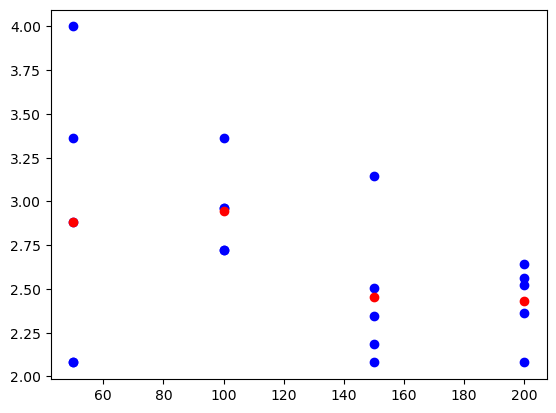

In [8]:
import matplotlib.pyplot as plt

def avg_results(arr):
    return np.mean(arr, axis=1)


def plot(n_count, n_start, n_end, n_step, sets, results):
        for i in range(n_count):
            plt.scatter(np.array((i*n_step+n_start,)*sets), results[i],
                        label=f'Row {i}', color="b")

        plt.scatter(np.arange(n_start, n_end+1, n_step), avg_results(results), color="r")
        plt.show()


plot(monte.n_count, monte.n_start, monte.n_end, monte.n_step, monte.sets, arr)


What about using monte carlo method to calculate area of some set. Currently we cannont do that, but that can be fixed. All we need is to add custom function for checking if a point is insdie or outside the set and manually input y range. Lets calculate value of pi then.

Note that circle with radius 1 has area equal to pi and point is inside the circle if it's distance from circle's center is no greater than circle's radius. In this case counting points as negative is not needed.

In [9]:
import math
def pi_eval_fun(fun, point:(np.single, np.single)) -> int:
    if math.dist((0,0),point) <= 1.0:
        return 1
    return 0

Lets modify Calculator class. If we set default arguments for min_val, max_val and evaluation function as None we have the exact same situation as before.

In [10]:
class Calculator:
    def __init__(self, start: float, stop: float, fun_to_integrate, n_start=50, n_end=5000, n_step=50, sets=50, 
        min_val = None, max_val = None, eval = None):
        self.a = start
        self.b = stop
        self.fun = fun_to_integrate
        self.n_start = n_start
        self.n_end = n_end
        self.n_step = n_step
        self.sets = sets
        self.n_count = (n_end - n_start)//n_step + 1
        
        if min_val == None and max_val == None:
            self.min, self.max = min_max(fun_to_integrate,self.a, self.b)
        else:
            self.min = min_val
            self.max = max_val
        if eval == None:
            self.eval_function = deafault_eval_fun
        else:
            self.eval_function = eval

    def do_one_n(self, n: int) -> int:
        count = 0
        for _ in range(n):
            x = random.uniform(self.a, self.b)
            y = random.uniform(self.min, self.max)
            count += self.eval_function(self.fun,(x,y))
        return count

       